# Designing fast optimal SNAP gates in superconducting resonators
**Engineering fast, leakage-free gates in superconducting cavity-qubit systems**

Boulder Opal provides a [module designed to simulate and optimize superconducting systems](https://docs.q-ctrl.com/boulder-opal/tutorials/simulate-and-optimize-dynamics-with-the-superconducting-systems-module).
The exceptional size of the Hilbert space of quantum oscillators can be viewed as a resource to encode and process quantum information, but can also introduce channels for gate-performance degradation.
For instance, leakage to unwanted levels due to the spectral content of a control waveform can arise as the number of relevant oscillator modes increases.
In practice, long pulse durations are used to narrow the operation's spectral range and, consequently, prevent leakage to neighboring levels. Longer gates, however, expose the system to other limiting factors such as spontaneous decay and cavity losses. 

In this notebook, you'll have the opportunity to use Boulder Opal optimization tools to make Selective Number-dependent Arbitrary Phase (SNAP) gates with transmons faster while suppressing leakage at the same time.  We will cover:
- Simulating leakage in SNAP gates.
- Optimizing fast SNAP gates which suppress leakage to a ladder of states in a harmonic oscillator.
- Validating optimized gate performance using simulation.

Ultimately we will show how model-based numeric optimization provides a means to dramatically enhance gate speed without performance degradation in qubit-oscillator systems.

## Imports and initialization

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import qctrlvisualizer as qv

import boulderopal as bo

# Plotting style.
plt.style.use(qv.get_qctrl_style())

# Data containers.
controls = {}
simulation_results = {}

## Evaluating a standard SNAP gate

The system consists of a superconducting transmon system coupled to a cavity in the dispersive limit, as given by the following Hamiltonian:

$$H = \omega_C a^\dagger a + \frac{K}{2} (a^\dagger)^2 a^2 + \omega_T b^\dagger b + \chi a^\dagger a b^\dagger b, $$

where $\omega_C$ is the cavity transition frequency, $a$ is the annihilation operator of a cavity excitation, $b$ is the annihilation operator of the transmon system, $K$ is the Kerr coefficient, $\omega_T$ is the transmon frequency, and $\chi$ is the dispersive shift. The basis states in the Hilbert space will be denoted by $|i,j\rangle =|i\rangle_T \otimes |j\rangle_C$, for the transmon number state $|i\rangle_T$ and cavity number state $|j\rangle_C$.

For a complex drive $\gamma(t)= I(t) + i Q(t)$ applied to the transmon with frequency $\omega_D$, the Hamiltonian can be written in the interaction picture with respect to $\omega_C a^\dagger a + \omega_D b^\dagger b$:

$$H_I = \frac{K}{2} (a^\dagger)^2 a^2 + \delta_T b^\dagger b + \chi a^\dagger a b^\dagger b + \left(\gamma (t) b + H.c.\right), $$

where $\delta_T = \omega_T - \omega_D$.

Only the lowest two energy levels of the transmon system are treated in this notebook, such that there is no transmon anharmonicity term in $H_I$ to characterize higher-energy transmon states. Note that in this configuration, the transmon qubit will exhibit a spectrum of transition frequencies, set $\chi$ apart, each corresponding to a different excitation state of the cavity.

The objective of a SNAP gate is to impart a phase of $\theta$ to a target Fock state $j$ of the cavity $|j\rangle_C \rightarrow e^{i\theta} |j\rangle_C $. The [standard implementation](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.137002) of SNAP gates consists of two control $\pi$ pulses applied on the transmon qubit based on a target Fock state of the cavity. The pulses are performed around different axes, offset apart by an angle $\theta$. By the end of the gate, the qubit makes a net $2\pi$ rotation, disentangling from the targeted Fock state while imparting the desired phase $\theta$ to it.

### Obtaining a standard SNAP gate

To set up the system to evaluate a SNAP gate, we first define the basic parameters and target operation. Note that the transmon drive detuning is determined by the target cavity Fock state, to resolve a particular transition frequency.

In [2]:
K = 2 * np.pi * 4e3  # rad.Hz
chi = 2 * np.pi * 1.189e6  # rad.Hz

# SNAP gate parameters.
target_fock_n = 1  # Fock state that the SNAP gate is targeting.
theta = np.pi / 2  # SNAP gate angle.
delta_T = -chi * target_fock_n  # transmon detuning.
rabi_rate = 0.2 * chi

Next we generate the standard SNAP drive control.

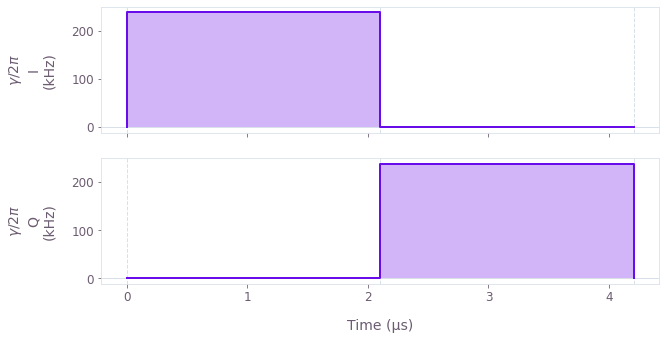

In [3]:
controls["Standard"] = {
    "$\\gamma$": {
        "durations": np.pi / rabi_rate * np.ones(2),
        "values": rabi_rate * np.exp([0, 1j * (np.pi - theta)]),
    }
}
qv.plot_controls(controls["Standard"], polar=False)

The plots display the drive pulses $\gamma(t)$ applied on the transmon qubit. Note that since the standard SNAP gates demand high spectral selectivity, the qubit Rabi rates need to be smaller than the qubit-cavity coupling $|\gamma| < \chi$, making the gate relatively long as in [Heeres et al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.137002).

### Simulating the system evolution under the standard controls

We can now simulate the evolution of the system. For this purpose, the first four states of the cavity ($n_c=4$) will be evenly populated while the qubit will be initialized in the ground state $| 0\rangle_T$, making the total initial state: $(|0, 0\rangle + |0, 1\rangle + |0, 2\rangle + |0, 3\rangle)/2$. 

We target the first Fock state $|1\rangle_C$ with the SNAP gate, evolving the initial state into $(|0, 0\rangle + e^{i\theta}|0, 1\rangle + |0, 2\rangle + |0, 3\rangle)/2$, for the gate angle $\theta$, here chosen to be $\theta=\pi/2$.

First, we set up the simulation parameters, relevant states, and create objects describing the system.
You can learn more about the superconducting systems module in [this tutorial](https://docs.q-ctrl.com/boulder-opal/tutorials/simulate-and-optimize-dynamics-with-the-superconducting-systems-module).

In [4]:
# Simulation dimensions for the transmon and cavity.
transmon_dimension = 2
cavity_dimension = 4

# Gate parameters.
drive_control_values = controls["Standard"]["$\\gamma$"]["values"]
gate_duration = np.sum(controls["Standard"]["$\\gamma$"]["durations"])
sample_points = 512  # Number of evolution samples.

# Initial and target states.
transmon_ground_state = np.zeros(transmon_dimension)
transmon_ground_state[0] = 1
cavity_initial_state = np.ones(cavity_dimension, dtype=complex)
cavity_initial_state = cavity_initial_state / np.sqrt(cavity_dimension)
initial_state = np.kron([transmon_ground_state], [cavity_initial_state])[0]

cavity_target_state = cavity_initial_state
cavity_target_state[target_fock_n] *= np.exp(1j * theta)
target_state = np.kron([transmon_ground_state], [cavity_target_state])[0]

# Transmon, cavity, and interaction objects.
transmon = bo.superconducting.Transmon(
    dimension=transmon_dimension, frequency=delta_T, drive=drive_control_values
)

cavity = bo.superconducting.Cavity(dimension=cavity_dimension, kerr_coefficient=K)

interaction = bo.superconducting.TransmonCavityInteraction(dispersive_shift=chi)

Next, we perform the simulation.

In [5]:
simulation_results["Standard"] = bo.superconducting.simulate(
    transmons=[transmon],
    cavities=[cavity],
    interactions=[interaction],
    gate_duration=gate_duration,
    initial_state=initial_state,
    sample_count=sample_points,
)

Your task (action_id="1827929") has started.
Your task (action_id="1827929") has completed.


To understand the evolution of the cavity states under the standard SNAP gate, it's instructive to plot both the probabilities and the phases of all the $|0,n\rangle$ states. In the below cell, we extract these values and plot the dynamics.

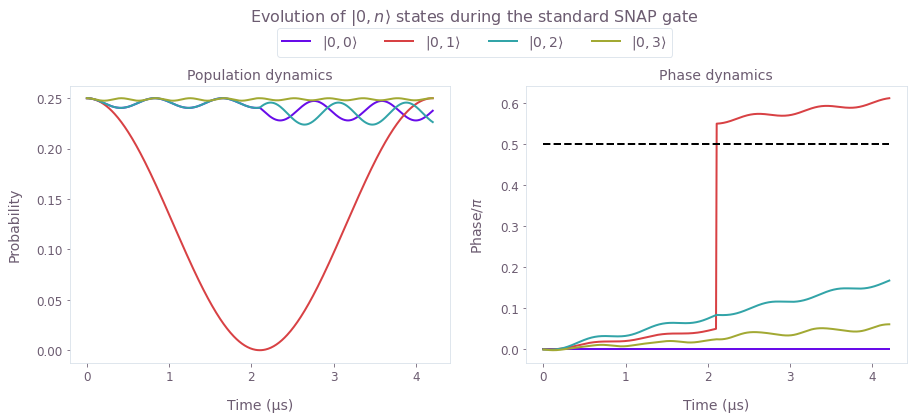

In [6]:
def plot_ground_states_dynamics(result, n_t, n_c, name):
    states = result["output"]["state_evolution"]["value"]
    sample_times = result["output"]["sample_times"]["value"]

    # Reshape states into [time, transmon, cavity]
    # and take the probability coefficients for the transmon ground state.
    ground_states = np.reshape(states, [-1, n_t, n_c])[:, 0, :]

    # Calculate populations.
    populations = np.abs(ground_states) ** 2

    # Calculate phases with respect to 0-th cavity state.
    phases = np.angle(ground_states)
    phases = phases - phases[:, :1]

    # Plot populations and phases.
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(
        rf"Evolution of $|0,n\rangle$ states during the {name} SNAP gate", y=1.1
    )

    axs[0].set_xlabel("Time (µs)")
    axs[0].set_ylabel(r"Probability")
    axs[0].set_title(r"Population dynamics")
    axs[0].plot(sample_times / 1e-6, populations)

    axs[1].set_xlabel("Time (µs)")
    axs[1].set_ylabel(r"Phase$/\pi$")
    axs[1].set_title(r"Phase dynamics")
    axs[1].plot(sample_times / 1e-6, phases / np.pi)
    axs[1].plot([0, sample_times[-1] / 1e-6], [theta / np.pi, theta / np.pi], "k--")

    labels = [rf"$|0,{n}\rangle$" for n in range(4)]
    fig.legend(labels=labels, loc="center", bbox_to_anchor=(0.5, 1.0), ncol=4)

    plt.show()


plot_ground_states_dynamics(
    simulation_results["Standard"], transmon_dimension, cavity_dimension, "standard"
)

Here we present the evolution of population (left) and relative phase (right) of the $|0,n\rangle$ states under the SNAP gate targeting $|1\rangle_C$ Fock state. The standard controls induce significant leakage into the neighboring states the which can only be contained by significantly extending the gate duration. Observe that the phase of $|0,1\rangle$ changes from 0 to $\pi/2$ in line with the offset between the two $\pi$-pulse frames, however the phases of neighboring Fock states suffer from a nontrivial combination of leakage and Kerr effect, drifting away from the target phase difference of $\pi/2$ indicated by the dashed black line.

## Creating Boulder Opal fast SNAP gates optimized for leakage suppression

We now use the optimization engine in Boulder Opal to obtain control pulses that perform a faster SNAP while minimizing leakage to other Fock states in the cavity. In this case, the unitary target operation will be $e^{i\theta}|0,1\rangle\langle 0,1|$ projected onto the $|0\rangle\langle 0|_T \otimes I_C $ subspace since the final population of the qubit's excited state will be zero by the end of the gate.

### Generating a control pulse

To optimize a control pulse, we first specify optimization parameters such as the number of pulse segments and the target operation, as described in the [Simulate and optimize dynamics with the superconducting systems module](https://docs.q-ctrl.com/boulder-opal/tutorials/simulate-and-optimize-dynamics-with-the-superconducting-systems-module) tutorial.
We obtain smooth control pulses by applying a sinc filter with a specified cutoff frequency: here the maximum Rabi rate is also used as the cutoff frequency for the control.

In [7]:
# Optimization parameters.
max_rabi_rate = 4.5 * chi
cutoff_frequency = max_rabi_rate  # Sinc filter cutoff frequency.
gate_duration = 1e-6  # s
number_of_optimizer_vars = 64
number_of_segments = 256  # Smooth control segments.
optimization_count = 4  # Number of optimization runs.

# Target operation in the appropriate subspace.
SNAP_cavity_target_state = np.zeros(cavity_dimension)
SNAP_cavity_target_state[target_fock_n] = 1.0
cavity_target_operation = expm(
    (1j * theta) * np.outer(SNAP_cavity_target_state, SNAP_cavity_target_state)
)
full_target_operation = np.kron(np.eye(transmon_dimension), cavity_target_operation)
cavity_subspace_projector = np.diag(
    np.kron(np.array([1.0, 0.0]), np.ones(cavity_dimension))
)
subspace_target = np.matmul(full_target_operation, cavity_subspace_projector)

# Update transmon object to make drive optimizable.
transmon.drive = bo.superconducting.ComplexOptimizableSignal(
    number_of_optimizer_vars, max_rabi_rate
)

# Run optimization.
result = bo.superconducting.optimize(
    transmons=[transmon],
    cavities=[cavity],
    interactions=[interaction],
    gate_duration=gate_duration,
    initial_state=initial_state,
    target_operation=subspace_target,
    cutoff_frequency=cutoff_frequency,
    sample_count=number_of_segments,
    optimization_count=optimization_count,
)
print(f"Final infidelity achieved: {result['output']['infidelity']['value']:.3e}")

Your task (action_id="1827947") is queued.
Your task (action_id="1827947") has started.
Your task (action_id="1827947") has completed.
Final infidelity achieved: 5.558e-11


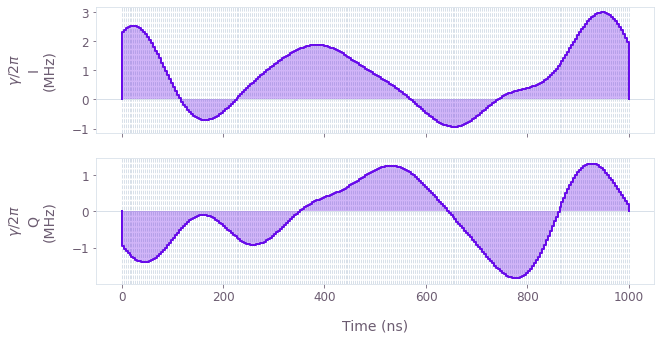

In [8]:
# Extract optimized controls.
controls["Q-CTRL"] = {"$\\gamma$": result["output"]["transmon.drive_filtered"]}
qv.plot_controls(controls["Q-CTRL"], polar=False)

# Save simulation results.
simulation_results["Q-CTRL"] = result

The plot above displays the pulses for the optimized SNAP gate. The maximum Rabi rate and cutoff frequency of these controls is set sufficiently high to ensure that all of the populated cavity levels can be simultaneously addressed.

### State leakage analysis using simulation

To observe the dynamics, we plot the state evolution under the optimized SNAP gate.
We can extract the simulated evolution of the system from the optimization result, and plot it as in the standard case.

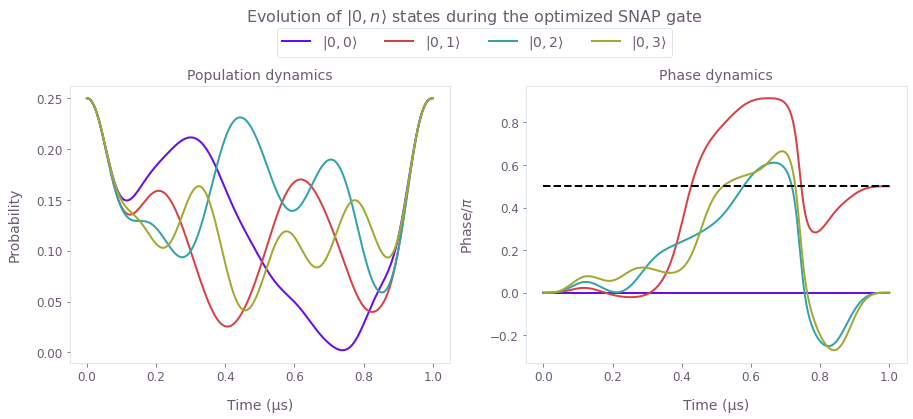

In [9]:
plot_ground_states_dynamics(
    simulation_results["Q-CTRL"], transmon_dimension, cavity_dimension, "optimized"
)

Plotted are the populations (left) and relative phases (right) of the $|0,n\rangle$ states during the optimized SNAP gate. The control solution generated using Boulder Opal is shorter than the standard gate because it allowed us to leverage a higher Rabi rate. The impact of leakage is actively controlled throughout the gate, ensuring that the neighboring Fock state populations follow their individual trajectories back to the original starting point. Observe that the relative phases of the states evolve in such a way that the phase of the targeted $|1\rangle_C$ state reaches the specified target value $\theta =\pi/2$ by the end of the gate (indicated by the dashed black line), while phases of the neighboring states converge to 0, in the process also eliminating the effects of the Kerr term.